In [1]:
import sys
sys.path.insert(0, '/home/johnr_000/jupyter_blog/jupyter_blog/scripts')
import eia_model as em
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from datetime import datetime

In [22]:
#variables to specify date range and frequency
api_key = em.eia_api
start = '2015-12-01 01:00:00'
end = '2016-01-31 23:00:00'
freq = 'H'
# create list of series used for dictionary keys
keys = ['EBA.BPAT-ALL.D.H', 'EBA.PACE-ALL.D.H', 'EBA.PACW-ALL.D.H', 
        'EBA.PGE-ALL.D.H', 'EBA.PSEI-ALL.D.H', 'EBA.SCL-ALL.D.H']
# create dict of GetSeriesRange objects from series list
# series_dict = {key: em.GetSeries(api_key=api_key, series_id=key, 
#                                    start=start, end=end, freq=freq) for key in keys}

In [20]:
# loop over dictionary and print out full name of each series
for key in series_dict:
    print('{}: {}'.format(series_dict[key].data.series[0]['name'],key))

Demand for PacifiCorp West (PACW), Hourly: EBA.PACW-ALL.D.H
Demand for Seattle City Light (SCL), Hourly: EBA.SCL-ALL.D.H
Demand for Portland General Electric Company (PGE), Hourly: EBA.PGE-ALL.D.H
Demand for Puget Sound Energy, Inc. (PSEI), Hourly: EBA.PSEI-ALL.D.H
Demand for Bonneville Power Administration (BPAT), Hourly: EBA.BPAT-ALL.D.H
Demand for PacifiCorp East (PACE), Hourly: EBA.PACE-ALL.D.H


In [21]:
# TODO: change this code so that series_dict is output to json
# all the dataframes have the same date range so we can concatenate in a loop
concat_df = pd.concat([series_dict[key].data.df for key in series_dict], axis=1)
# and output as a pickle file - I'm doing this to avoid calling the EIA API as I develop
concat_df.to_pickle('data/nw_load_df.pkl')
# concat_df = pd.read_pickle('data/new_load_df.pkl')

In [5]:
concat_df = pd.read_pickle('/home/johnr_000/jupyter_blog/jupyter_blog/data/nw_load_df.pkl')

In [6]:
concat_df['HOUR'] = concat_df.index.to_datetime().hour

In [56]:
class PredictOutliers(object):
    
    def __init__(self, series_id, train_df):
        self.series_id = series_id
        self.train_df = train_df[['HOUR', self.series_id]].interpolate(method='linear')
        self.training_data = self.train_df[['HOUR', self.series_id]].values
        self.clf = self.fit_clf()
        self.pred_df = pd.concat([self.train_df, self.create_predictions()], axis=1)
        
    def fit_clf(self):
        clf = IsolationForest(contamination=.01)
        return clf.fit(self.training_data)
        
    def create_predictions(self):
        opred = self.clf.predict(self.training_data)
        dfunc = self.clf.decision_function(self.training_data)
        l1 = '{}{}'.format(self.series_id, '_opred')
        l2 = '{}{}'.format(self.series_id, '_dfunc')
        return pd.DataFrame(np.column_stack((opred, dfunc)), index=self.train_df.index.values, columns=[l1, l2])

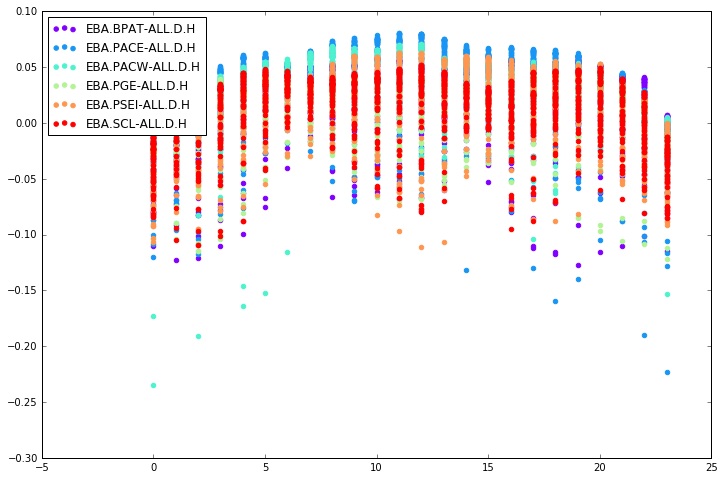

In [58]:
# Two subplots, the axes array is 1-d
fig = plt.figure(figsize=(12, 8), dpi=100)
colors = plt.cm.rainbow(np.linspace(0, 1, len(keys)))
for key, color in zip(keys, colors):
    pred_df = PredictOutliers(key, concat_df).pred_df
    plt.scatter(pred_df['HOUR'].values, pred_df['{}{}'.format(key, '_dfunc')].values, 
                color=color, label=key)
legend = plt.legend(loc='upper left')
plt.show()

In [ ]:
# TODO need to create a dictionary with series pred_dataframes
# Need to create graph above then loop through series dataframe and replace with NaN based on threshold